# Setup and utils

In [1]:
%cd ..
from utils import *
%cd CIFAR

/home/arnisaf/mp-tl-study
/home/arnisaf/mp-tl-study/CIFAR


In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if using multi-GPU

# THEORETICAL EXPERIMENT

## Setup

In [3]:
percentages = [0.001, 0.01, 0.1, 0.5, 1.0]
#percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]

# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3,4,5,6]
#seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
batch_size = 64

In [4]:
import torch
from torchvision import datasets, transforms
import math

class CustomCNN(nn.Module):
    def __init__(self, params, output_dim):
        super(CustomCNN, self).__init__()
        self.params = params

        # Change initial number of input channels for RGB images
        in_channels = 3

        for i in range(params["depth"]):
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, params["num_channels"], kernel_size=params["kernel_size"], padding=math.floor(params["kernel_size"]/2)))
            setattr(self, f"act{i}", params["activation_function"]())

            if params["use_pooling"] and (i+1) % 2 == 0:
                setattr(self, f"pool{i}", nn.AvgPool2d(2, stride=2))

            in_channels = params["num_channels"]

        self.calculate_to_linear_size()

        self.fc = nn.Linear(self._to_linear, output_dim)

    def calculate_to_linear_size(self):
        # Adjust the dummy input tensor for CIFAR-10
        x = torch.zeros(1, 3, 32, 32)
        for layer_name, layer in self.named_children():
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            elif "pool" in layer_name:
                x = layer(x)
            elif isinstance(layer, nn.Linear):
                break
        self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        for layer_name, layer in self.named_children():
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            elif "pool" in layer_name:
                x = layer(x)
            elif isinstance(layer, nn.Linear):
                break

        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # Changed to cross_entropy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

In [6]:
# Changes Here for the experiments
params = {
      # MODEL ARCHITECTURE PARAMS
      'depth': 6,
      'num_channels': 64,
      'width':64,
      # 'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 3,
      # TRAINING PARAMS
      'device': device,
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 10,
      'early_stop_patience': 5,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'batch_size':batch_size,
      # DATASET PARAMS
      'pre_train_classes': [0, 1, 8, 9], #[2, 3, 4, 5, 6, 7]
      'fine_tune_classes': [2, 3, 4, 5, 6, 7],
        'val_split': 0.1,
      'num_workers': 0,
      'generate_dataset_seed': 42,
      # EXPERIMENT SETTING PARAMS
      'percentages':percentages,
      'use_pooling': True,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': True,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

In [7]:
root_dir = './data'  # Specify your data directory here
transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
dataloader_wrapped = TransferLearningWrapper(params, datasets.CIFAR10, datasets.CIFAR10, root_dir, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Pretraining



In [9]:
pretrained_model = CustomCNN(params, dataloader_wrapped.output_dim)
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (pool5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=4, bias=True)
)

In [10]:
pretrained_model.load_state_dict(torch.load('pretrained_models/pretrained_model_Vehicles_constant_channels/modelcifar10_vehicles_cpu.pth'))
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (pool5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=4, bias=True)
)

In [11]:
eval(pretrained_model, device, dataloader_wrapped.test_loader, debug=True, classification_report_flag=True, is_cnn=True)


Average loss: 0.1832, Accuracy: 18689.0/20000 (93%)

              precision    recall  f1-score   support

     Class 0       0.91      0.95      0.93      5000
     Class 1       0.97      0.92      0.95      5000
     Class 2       0.94      0.93      0.93      5000
     Class 3       0.92      0.94      0.93      5000

    accuracy                           0.93     20000
   macro avg       0.94      0.93      0.93     20000
weighted avg       0.94      0.93      0.93     20000



0.93445

In [6]:
"""trainer = Trainer(pretrained_model, dataloader_wrapped, params["lr_pretrain"], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")"""

Epoch: 0 	Training Accuracy: 56.53%
Validation Accuracy: 56.21%


KeyboardInterrupt: 

# Crazy Parts

### Functions

In [12]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import patheffects
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import json
import torch.nn as nn
from sklearn.decomposition import PCA

In [13]:
class CustomCNN(nn.Module):
    def __init__(self, params, output_dim):
        super(CustomCNN, self).__init__()
        self.params = params

        # Change initial number of input channels for RGB images
        in_channels = 3

        for i in range(params["depth"]):
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, params["num_channels"], kernel_size=params["kernel_size"], padding=math.floor(params["kernel_size"]/2)))
            setattr(self, f"act{i}", params["activation_function"]())

            if params["use_pooling"] and (i+1) % 2 == 0:
                setattr(self, f"pool{i}", nn.AvgPool2d(2, stride=2))

            in_channels = params["num_channels"]

        self.calculate_to_linear_size()

        self.fc = nn.Linear(self._to_linear, output_dim)

    def calculate_to_linear_size(self):
        # Adjust the dummy input tensor for CIFAR-10
        x = torch.zeros(1, 3, 32, 32)
        for layer_name, layer in self.named_children():
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            elif "pool" in layer_name:
                x = layer(x)
            elif isinstance(layer, nn.Linear):
                break
        self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        for layer_name, layer in self.named_children():
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            elif "pool" in layer_name:
                x = layer(x)
            elif isinstance(layer, nn.Linear):
                break

        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [41]:
class CIFAR10CNNFeatureExtractor(nn.Module):
    def __init__(self, params, output_dim):
        super(CIFAR10CNNFeatureExtractor, self).__init__()

        # Change initial number of input channels for RGB images
        in_channels = 3

        for i in range(params["depth"]):
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, params["num_channels"], kernel_size=params["kernel_size"], padding=math.floor(params["kernel_size"]/2)))
            setattr(self, f"act{i}", params["activation_function"]())

            if params["use_pooling"] and (i+1) % 2 == 0:
                setattr(self, f"pool{i}", nn.AvgPool2d(2, stride=2))

            in_channels = params["num_channels"]

        self.calculate_to_linear_size()

        self.fc = nn.Linear(self._to_linear, output_dim)

    # calculate the input dimensions to the fully-connecting layer by forwarding a dummy input
    def calculate_to_linear_size(self):
        x = torch.zeros(1, 3, 32, 32)
        for layer_name, layer in self.named_children():
            # Process the input tensor through convolutional and activation layers
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            # Process the input tensor through pooling layers if they exist
            elif "pool" in layer_name:
                x = layer(x)
            # If reached fully connected layers, break the loop
            elif isinstance(layer, nn.Linear):
                break
        self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        outputs = {}
        outputs["input"] = x.cpu()
        # Iterate over each module in the CustomCNN class
        for layer_name, layer in self.named_children():
            # Process the input tensor through convolutional and activation layers
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            # Process the input tensor through pooling layers if they exist
            elif "pool" in layer_name:
                x = layer(x)
            # If reached fully connected layers, break the loop
            elif isinstance(layer, nn.Linear):
                break
            if "conv" in layer_name or "fc" in layer_name:
                outputs[layer_name] = torch.mean(x, dim=(1)).cpu()

        x = x.view(-1, self._to_linear) # Flatten
        x = self.fc(x)
        outputs["fc"] = F.log_softmax(x, dim=1).cpu()
        return outputs

    def get_features_layers(self):
        names = []
        for layer_name, _ in self.named_children():
            if "conv" in layer_name or "fc" in layer_name:
                names.append(layer_name) 
        return names         

In [44]:
feature_extractor = CIFAR10CNNFeatureExtractor(params, dataloader_wrapped.output_dim).to(device)
feature_extractor.load_state_dict(torch.load('pretrained_models/pretrained_model_Vehicles_constant_channels/modelcifar10_vehicles_cpu.pth'))

<All keys matched successfully>

In [45]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    features_from_layers = {layer: [] for layer in feature_extractor.get_features_layers()}
    features_from_layers["input"] = []
    labels_list = []

    with torch.no_grad():
        for images, labels in data_loader:
            labels_list.extend(labels.numpy())

            images = images.to(device)

            # Extract features
            out_features = model(images)

            # Store features from each layer
            for name, feature in out_features.items():
                features_from_layers[name].append(feature)
    
    # Concatenate the features from all batches
    for layer in features_from_layers:
        features_from_layers[layer] = torch.cat(features_from_layers[layer], 0)

    return features_from_layers, torch.Tensor(labels_list)

def visualize_tsne(features, labels, layer_name, title):
    # Reshape features to 2D array
    features_2d = features.view(features.size(0), -1).numpy()

    # Apply t-SNE to reduce the dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features_2d)

    # Plot t-SNE visualization for the layer
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
    plt.title(f't-SNE Visualization of Extracted Features ({layer_name} - {title})')
    plt.colorbar()
    plt.show()

def calculate_ARI_score(features, labels, apply_pca=None):
    # Reshape features to 2D array
    features_2d = features.view(features.size(0), -1).numpy()
    if apply_pca:
        pca = PCA(n_components=apply_pca)
        features_2d = pca.fit_transform(features_2d)

    # KMeans clustering labels
    kmeans = KMeans(n_clusters=np.unique(labels).shape[0], random_state=42)
    cluster_labels = kmeans.fit_predict(features_2d)

    # ARI 
    ari = metrics.adjusted_rand_score(labels, cluster_labels)
    return ari

# Dataloader can be already subsampled using our subsampling function (reduce_dataset)
# If yes, we can still use num_samples to randomly sample from that subset
# or if num_samples = 0: take all the samples
def get_ARI_scores(dataloader, num_samples, channel_ids, apply_pca=None):
    # Extract features and labels using the feature extractor model and the test_loader
    extracted_features, labels = extract_features_and_labels(feature_extractor, dataloader, device)

    dim_size = labels.size(0)

    if num_samples > 0:
        random_indices = torch.randperm(dim_size)[:num_samples]
        sampled_labels = torch.index_select(labels, 0, random_indices)
    else:
        sampled_labels = labels

    layer_names = extracted_features.keys()
    results = {}

    for layer_name in layer_names:
        results_channels = {}
        for channel_id in channel_ids:
            if channel_id < extracted_features[layer_name].shape[1]:
                if num_samples > 0:
                    sampled_features = torch.index_select(extracted_features[layer_name], 0, random_indices)
                    layer_features = sampled_features[:,channel_id]
                else:
                    sampled_features = extracted_features[layer_name]
                    layer_features = sampled_features[:,channel_id]
                ari = calculate_ARI_score(layer_features, sampled_labels, apply_pca=apply_pca)*100
                results_channels[channel_id] = ari
        results[layer_name] = results_channels
    return results

def plot_ARI_scores(ari_scores, channel_ids, layer_names, num_samples:str, dataset:str, split:str):
    # Extract mean and std for each layer
    mean_scores = [np.mean(list(ari_scores[layer].values())) for layer in layer_names]
    std_scores = [np.std(list(ari_scores[layer].values())) for layer in layer_names]

    # Create a box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot([list(ari_scores[layer].values()) for layer in layer_names], showmeans=True)

    plt.xticks(range(1, len(layer_names) + 1), [name+"\nmean: "+str(round(mean_scores[i]))+"\nstd: "+str(round(std_scores[i])) for i, name in enumerate(layer_names)])
    plt.xlabel('Layer')
    plt.ylabel('Scores (*100)')
    plt.title(f'ARI Scores for each CNN layer, {len(channel_ids)} channels, {num_samples} samples and {dataset} {split} dataset')
    plt.show()

def plot_ARI_scores_percentages(df, dataset, split, order=None):
    # Creating subplots for each data percentage
    unique_percentages = df['Percentage'].unique()
    #unique_percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]
    n_percentages = len(unique_percentages)

    # Adjusting the subplot layout for better readability of median values (improving contrast)
    fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=(10, 40), sharex=True)

    for i, percentage in enumerate(sorted(unique_percentages)):
        # Filtering data for each percentage
        df_subset = df[df['Percentage'] == percentage]
        
        # Creating a boxplot for the current percentage
        sns.boxplot(x='Layer', y='Max ARI Score', data=df_subset, ax=axes[i], order=order)
        axes[i].set_title(f'Percentage: {percentage}, Num Samples: {df_subset.iloc[0]["Num Samples"]}')
        axes[i].set_xlabel('Layer')
        # axes[i].set_ylim(0,100)
        # axes[i].set_yscale('log')

        if i == n_percentages - 1:
            axes[i].set_xlabel('Layer')
        else:
            axes[i].set_xlabel('')
        axes[i].set_ylabel('Max ARI Score')

        # Annotating each boxplot with the median value and adjusting for better contrast
        medians = df_subset.groupby(['Layer'])['Max ARI Score'].median().sort_index()
        for j, median in enumerate(medians):
            text = axes[i].text(j, median, f'{median:.3f}', 
                                horizontalalignment='center', size='small', color='white', weight='semibold')
            text.set_path_effects([patheffects.withStroke(linewidth=2, foreground="black")])
    st = fig.suptitle(f'ARI Scores, {dataset} {split} dataset')

    st.set_y(1.0)
    fig.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()

# Dataloader can be already subsampled using our subsampling function (reduce_dataset)
# If yes, we can still use num_samples to randomly sample from that subset
# or if num_samples = 0: take all the samples
def calculate_(dataloader, num_samples, channel_ids, apply_pca=None):
    # Extract features and labels using the feature extractor model and the test_loader
    extracted_features, labels = extract_features_and_labels(feature_extractor, dataloader, device)

    dim_size = labels.size(0)

    if num_samples > 0:
        random_indices = torch.randperm(dim_size)[:num_samples]
        sampled_labels = torch.index_select(labels, 0, random_indices)
    else:
        sampled_labels = labels

    layer_names = extracted_features.keys()
    results = {}

    for layer_name in layer_names:
        results_channels = {}
        for channel_id in channel_ids:
            if channel_id < extracted_features[layer_name].shape[1]:
                if num_samples > 0:
                    sampled_features = torch.index_select(extracted_features[layer_name], 0, random_indices)
                    layer_features = sampled_features[:,channel_id]
                else:
                    sampled_features = extracted_features[layer_name]
                    layer_features = sampled_features[:,channel_id]
                ari = calculate_ARI_score(layer_features, sampled_labels, apply_pca=apply_pca)*100
                results_channels[channel_id] = ari
        results[layer_name] = results_channels
    return results

In [82]:
from sklearn.metrics import davies_bouldin_score, pairwise_distances

dataloader_wrapped.update_phase('pretrain')
extracted_features, labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)

layer_names = extracted_features.keys()
results = {}

for layer_name in layer_names:
    features = extracted_features[layer_name]
    X = features.view(features.size(0), -1).numpy()
    distances = pairwise_distances(X, metric='cosine')

    # Calculate mean intra-cluster distances for each cluster
    mean_intra_cluster_distances = {}
    for cluster_label in np.unique(labels):
        cluster_mask = labels == cluster_label
        intra_cluster_distances = distances[cluster_mask][:, cluster_mask]
        mean_intra_cluster_distance = np.mean(intra_cluster_distances)
        mean_intra_cluster_distances[cluster_label] = mean_intra_cluster_distance

    # Calculate mean inter-cluster distance
    inter_cluster_distances = distances[~np.eye(len(X), dtype=bool)].reshape(len(X), -1)
    mean_inter_cluster_distance = np.mean(inter_cluster_distances)
    results[layer_name] = {"mean_intra_cluster_distances":mean_intra_cluster_distances, "mean_inter_cluster_distance":mean_inter_cluster_distance}


In [83]:
results

{'conv0': {'mean_intra_cluster_distances': {0.0: 0.4413703,
   1.0: 0.7016706,
   2.0: 0.436234,
   3.0: 0.6198644},
  'mean_inter_cluster_distance': 0.5641237},
 'conv1': {'mean_intra_cluster_distances': {0.0: 0.15754253,
   1.0: 0.15221407,
   2.0: 0.16765083,
   3.0: 0.15024886},
  'mean_inter_cluster_distance': 0.158983},
 'conv2': {'mean_intra_cluster_distances': {0.0: 0.21357286,
   1.0: 0.2468711,
   2.0: 0.17918119,
   3.0: 0.24392056},
  'mean_inter_cluster_distance': 0.224315},
 'conv3': {'mean_intra_cluster_distances': {0.0: 0.18800181,
   1.0: 0.19752422,
   2.0: 0.20237385,
   3.0: 0.21967456},
  'mean_inter_cluster_distance': 0.20734248},
 'conv4': {'mean_intra_cluster_distances': {0.0: 0.10129656,
   1.0: 0.12543947,
   2.0: 0.100264184,
   3.0: 0.10309075},
  'mean_inter_cluster_distance': 0.115354694},
 'conv5': {'mean_intra_cluster_distances': {0.0: 0.099694856,
   1.0: 0.11716424,
   2.0: 0.099762216,
   3.0: 0.09597312},
  'mean_inter_cluster_distance': 0.11497472},

In [84]:
for layer, result in results.items():
    mean_intra_cluster_distance = np.average(list(result["mean_intra_cluster_distances"].items()))
    print(f"{layer}: mean_inter_cluster_distance/mean_intra_cluster_distance = {result['mean_inter_cluster_distance']/mean_intra_cluster_distance}")

conv0: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.5504223108291626
conv1: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.1919025480747223
conv2: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.26069706678390503
conv3: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.24366091191768646
conv4: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.1435185819864273
conv5: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.14343614876270294
fc: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.38075053691864014
input: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.7753034830093384


In [47]:
extracted_features, labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)

In [40]:
x = out_features["conv0"]
torch.mean(x, dim=(1)).shape

torch.Size([56, 32, 32])

### tSNE Visualizations

In [27]:
dataloader_wrapped.update_phase('pretrain')

# Extract features and labels using the feature extractor model and the test_loader
train_extracted_features, train_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)
val_extracted_features, val_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.val_loader, device)
test_extracted_features, test_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.test_loader, device)

In [23]:
# sanity check
print(train_labels[:10])
print(torch.argmax(train_extracted_features["fc"][:10], dim=1))
print(test_labels[:10])
print(torch.argmax(test_extracted_features["fc"][:10], dim=1))

[2, 3, 3, 0, 3, 4, 3, 3, 2, 5]
tensor([2, 3, 3, 0, 3, 4, 3, 3, 2, 5])
[2, 1, 1, 5, 1, 4, 5, 4, 3, 4]
tensor([2, 1, 1, 5, 1, 4, 5, 4, 3, 4])


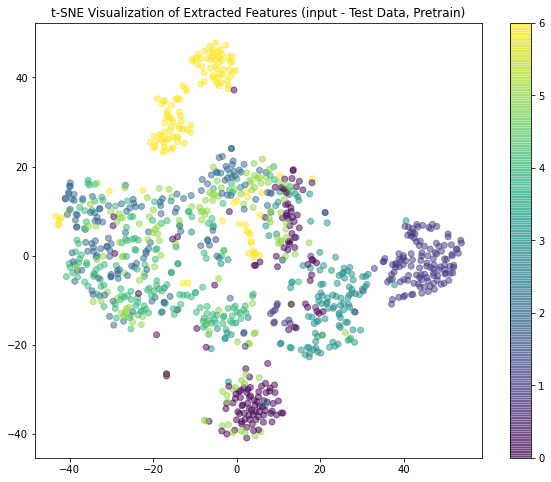

ARI of multidimensional KNN:  0.25170979240155095


In [24]:
# Visualize t-SNE for each layer in training data
# for layer_name, layer_features in train_extracted_features.items():
#    visualize_tsne(layer_features, train_labels, layer_name, "Training Data")

layer_name = "input"
layer_features = test_extracted_features[layer_name][:1000,0,:,:].unsqueeze(1)
# layer_features = test_extracted_features[layer_name][:1000,:].unsqueeze(1)
visualize_tsne(layer_features, test_labels[:1000], layer_name, "Test Data, Pretrain")
# Repeat for validation and test data if needed
ari = calculate_ARI_score(layer_features, test_labels[:1000])
print("ARI of multidimensional KNN: ", ari)

In [30]:
dataloader_wrapped.update_phase('finetune')

# Extract features and labels using the feature extractor model and the test_loader
train_extracted_features, train_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)
val_extracted_features, val_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.val_loader, device)
test_extracted_features, test_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.test_loader, device)

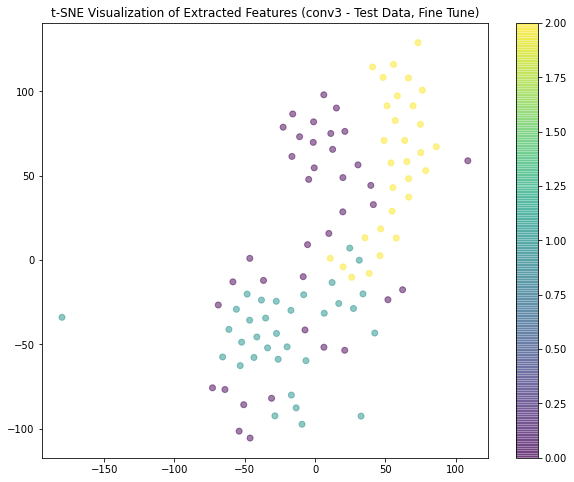

ARI of multidimensional KNN:  0.22551727215481726


In [41]:
# Visualize t-SNE for each layer in training data
# for layer_name, layer_features in train_extracted_features.items():
#    visualize_tsne(layer_features, train_labels, layer_name, "Training Data")

layer_name = "conv3"
layer_features = test_extracted_features[layer_name][-100:,0,:,:].unsqueeze(1)
# layer_features = test_extracted_features[layer_name][:1000,:].unsqueeze(1)
visualize_tsne(layer_features, test_labels[-100:], layer_name, "Test Data, Fine Tune")
# Repeat for validation and test data if needed
ari = calculate_ARI_score(layer_features, test_labels[-100:])
print("ARI of multidimensional KNN: ", ari)

### ARI Scores Plot

TypeError: 'AxesSubplot' object is not subscriptable

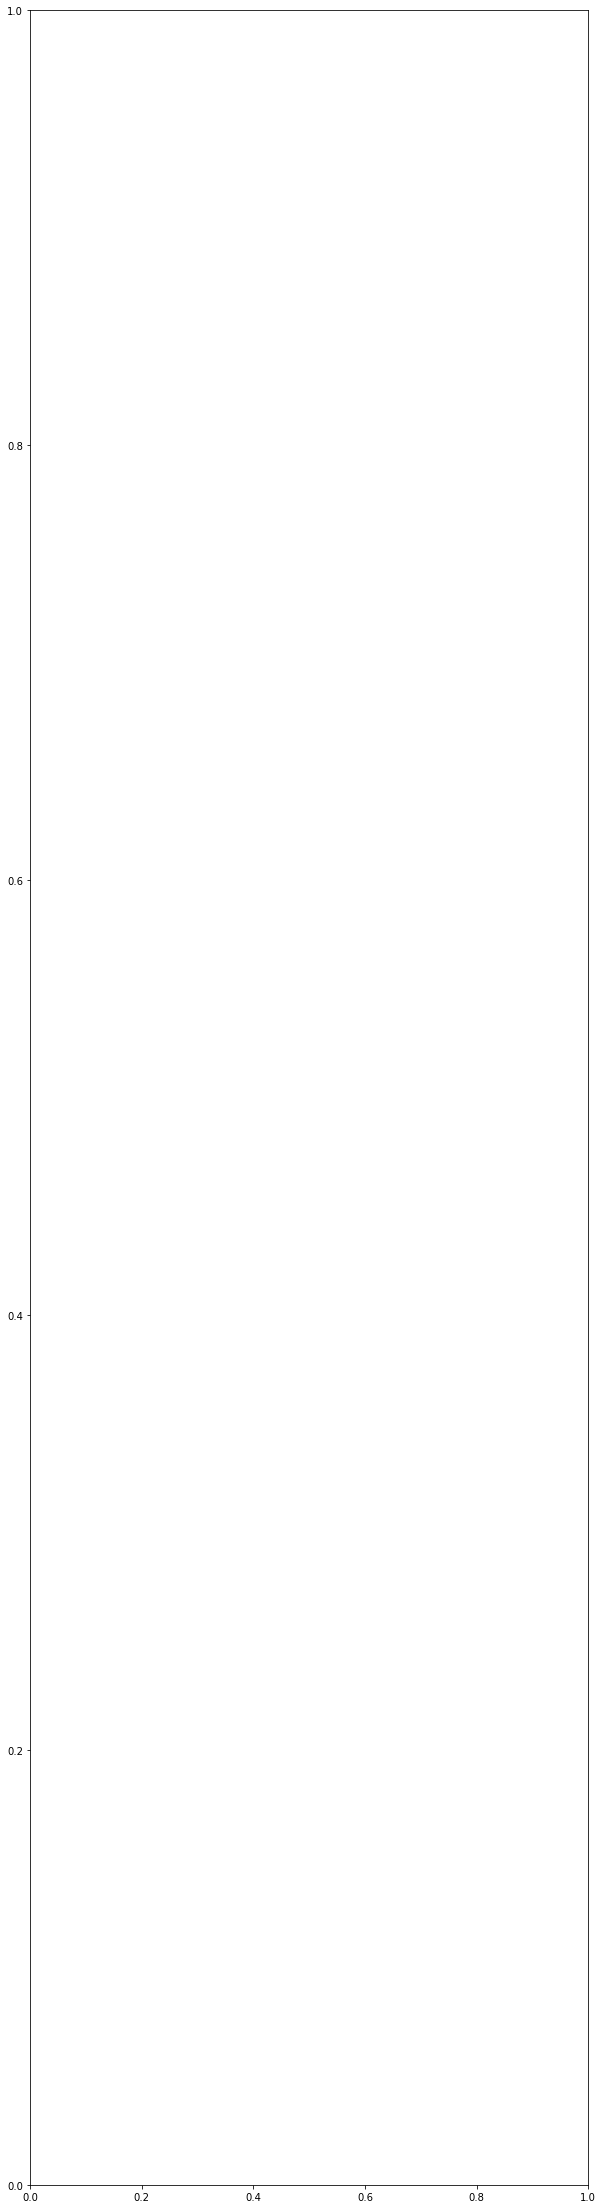

In [71]:
dataloader_wrapped.update_phase('finetune')
dataset_to_use = dataloader_wrapped.train_loader
num_samples = 1000
channel_ids = range(params["num_channels"])
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']
# channel_ids = [29]

ari_scores_all = []
# subset the dataset (same as the empirical experiment)
sampled_percentage = 0.1
repeat = 0
reduced_dataset = reduce_dataset(dataset_to_use, sampled_percentage, seed=repeat)
ari_scores = get_ARI_scores(reduced_dataset, 0, channel_ids, apply_pca=0)

# get the max of the channels -append to another dict
for layer, channels in ari_scores.items():
    max_channel = max(channels.items())
    ari_scores_all.append({"Percentage":sampled_percentage, "Repeat":repeat, "Num Samples":0, "Layer":layer, 
                            "Max ARI Score":np.max(list(channels.items())), "Avg ARI Score":np.average(list(channels.items())),
                            "Dataset":"Pretrain", "Split":"Train"})
# dict to df
df = pd.DataFrame(ari_scores_all)

# plot box plots: repeats
# box plot per percentage just like the other one: new function
# plot_ARI_scores_percentages(df, "Pretrain", "Train")

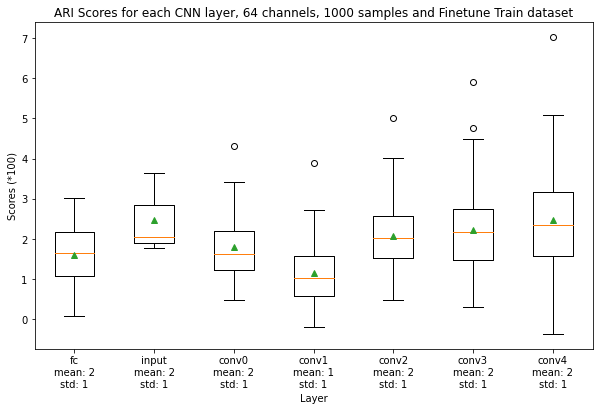

In [73]:
layer_names = ['fc', "input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4']
plot_ARI_scores(ari_scores, channel_ids, layer_names, num_samples=num_samples, dataset="Finetune", split="Train")

In [72]:
plot_ARI_scores(ari_scores, )

{'conv0': {0: 1.9392473879911425,
  1: 1.153982577342736,
  2: 0.954882664700719,
  3: 0.9406372275013968,
  4: 4.3190069279361945,
  5: 2.6785259154211634,
  6: 3.361058708719516,
  7: 1.4685194330953755,
  8: 1.211605841734031,
  9: 2.932280060446124,
  10: 1.6525186725354923,
  11: 1.6204047969930926,
  12: 1.6199661120907278,
  13: 1.583492155599216,
  14: 1.9671459574571832,
  15: 2.207697046593619,
  16: 2.4250612943038434,
  17: 1.994720656697973,
  18: 0.6876243055335604,
  19: 1.3866818404382066,
  20: 1.7847382784095656,
  21: 1.5622397320239054,
  22: 0.8392623394437703,
  23: 3.1971052355679714,
  24: 0.8059696405727186,
  25: 0.8851566290464352,
  26: 1.307105648792906,
  27: 2.0277770069650645,
  28: 2.7203171093942373,
  29: 2.025379116014738,
  30: 1.1431973030275435,
  31: 0.4810576602599726,
  32: 1.9931486247508543,
  33: 1.5901143233095605,
  34: 1.7456630001365374,
  35: 1.3831920048966149,
  36: 1.9824446560342786,
  37: 0.9294160033200037,
  38: 0.803329618538280

In [26]:
dataloader_wrapped.update_phase('pretrain')
dataset_to_use = dataloader_wrapped.train_loader
num_samples = 1000
channel_ids = range(params["num_channels"])
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']
# channel_ids = [29]

ari_scores_all = []
# subset the dataset (same as the empirical experiment)
for sampled_percentage in percentages:
    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 20
    else:
        repeats = 5
    print(f"Percentage:{sampled_percentage}")

    for repeat in tqdm(range(repeats)):
        reduced_dataset = reduce_dataset(dataset_to_use, sampled_percentage, seed=repeat)
        if num_samples < len(reduced_dataset.dataset):
            num_samples_tmp = num_samples
        else:
            num_samples_tmp = 0
        pretraining_ari_scores = get_ARI_scores(reduced_dataset,num_samples_tmp, channel_ids, apply_pca=50)

        # get the max of the channels -append to another dict
        for layer, channels in pretraining_ari_scores.items():
            max_channel = max(channels.items())
            ari_scores_all.append({"Percentage":sampled_percentage, "Repeat":repeat, "Num Samples":num_samples_tmp, "Layer":layer, 
                                   "Max ARI Score":np.max(list(channels.items())), "Avg ARI Score":np.average(list(channels.items())),
                                   "Dataset":"Pretrain", "Split":"Train"})
# dict to df
df = pd.DataFrame(ari_scores_all)

# plot box plots: repeats
# box plot per percentage just like the other one: new function
plot_ARI_scores_percentages(df, "Pretrain", "Train")

Percentage:0.001


  0%|          | 0/25 [00:10<?, ?it/s]


KeyboardInterrupt: 

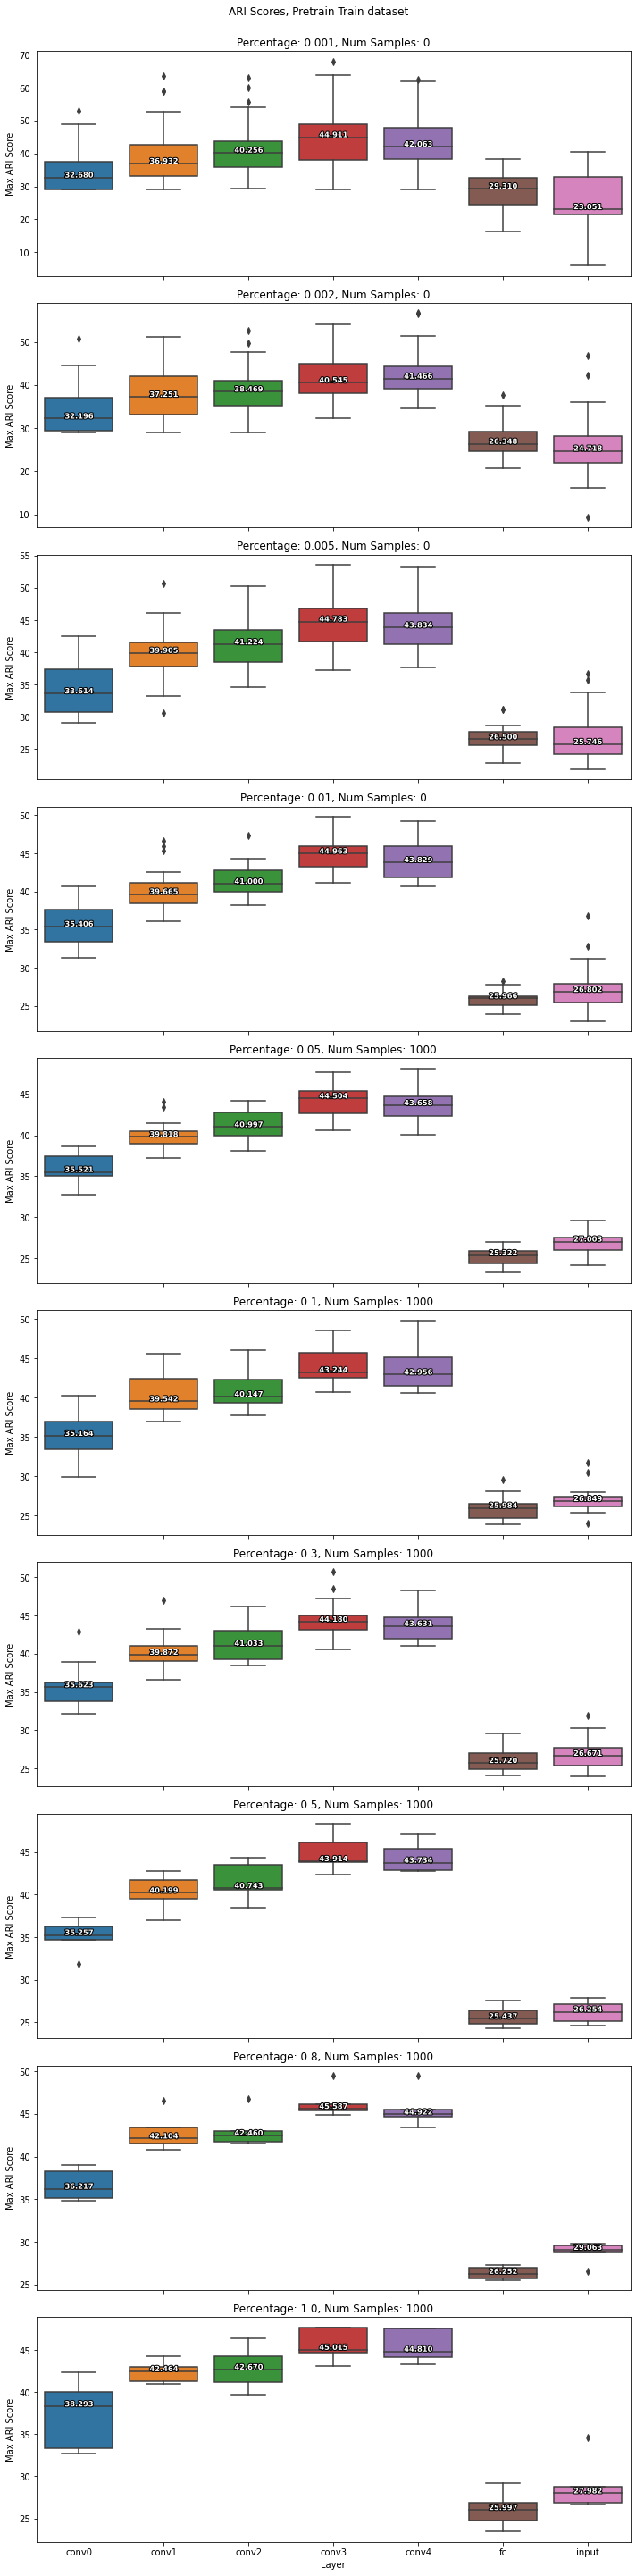

In [50]:
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']

plot_ARI_scores_percentages(df, "Pretrain", "Train", order=layer_names)

In [33]:
dataloader_wrapped.update_phase('finetune')
dataset_to_use = dataloader_wrapped.train_loader
num_samples = 100
channel_ids = range(params["num_channels"])
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3]
layer_names = ['fc', "input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4']
# channel_ids = [29]

ari_scores_all = []
# subset the dataset (same as the empirical experiment)
for sampled_percentage in percentages:
    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 20
    else:
        repeats = 5
    print(f"Percentage:{sampled_percentage}")

    for repeat in tqdm(range(repeats)):
        reduced_dataset = reduce_dataset(dataset_to_use, sampled_percentage, seed=repeat)
        if num_samples < len(reduced_dataset.dataset):
            num_samples_tmp = num_samples
        else:
            num_samples_tmp = 0
        pretraining_ari_scores = get_ARI_scores(reduced_dataset,num_samples_tmp, channel_ids, apply_pca=None)

        # get the max of the channels -append to another dict
        for layer, channels in pretraining_ari_scores.items():
            max_channel = max(channels.items())
            ari_scores_all.append({"Percentage":sampled_percentage, "Repeat":repeat, "Num Samples":num_samples_tmp, "Layer":layer, 
                                   "Max ARI Score":np.max(list(channels.items())), "Avg ARI Score":np.average(list(channels.items())),
                                   "Dataset":"Finetune", "Split":"Train"})
# dict to df
df = pd.DataFrame(ari_scores_all)

# plot box plots: repeats
# box plot per percentage just like the other one: new function
plot_ARI_scores_percentages(df, "Finetune", "Train")

Percentage:0.001


100%|██████████| 25/25 [21:09<00:00, 50.79s/it]


Percentage:0.002


100%|██████████| 25/25 [49:44<00:00, 119.39s/it] 


Percentage:0.005


100%|██████████| 25/25 [46:48<00:00, 112.32s/it] 


Percentage:0.01


100%|██████████| 25/25 [27:49<00:00, 66.78s/it]


Percentage:0.05


 60%|██████    | 12/20 [09:28<06:19, 47.44s/it]

In [ ]:
with open(f'results_jsons/ari/ari_scores_finetuned_Fashion_to_MNIST.json', 'w') as f:
    json.dump(ari_scores_all, f)

In [17]:
with open("results_jsons/ari/ari_scores_finetuned.json", "r") as f:
    ari_scores_all = json.load(f)
df = pd.DataFrame(ari_scores_all)

In [15]:
df = df[df["Percentage"] <= 0.3]

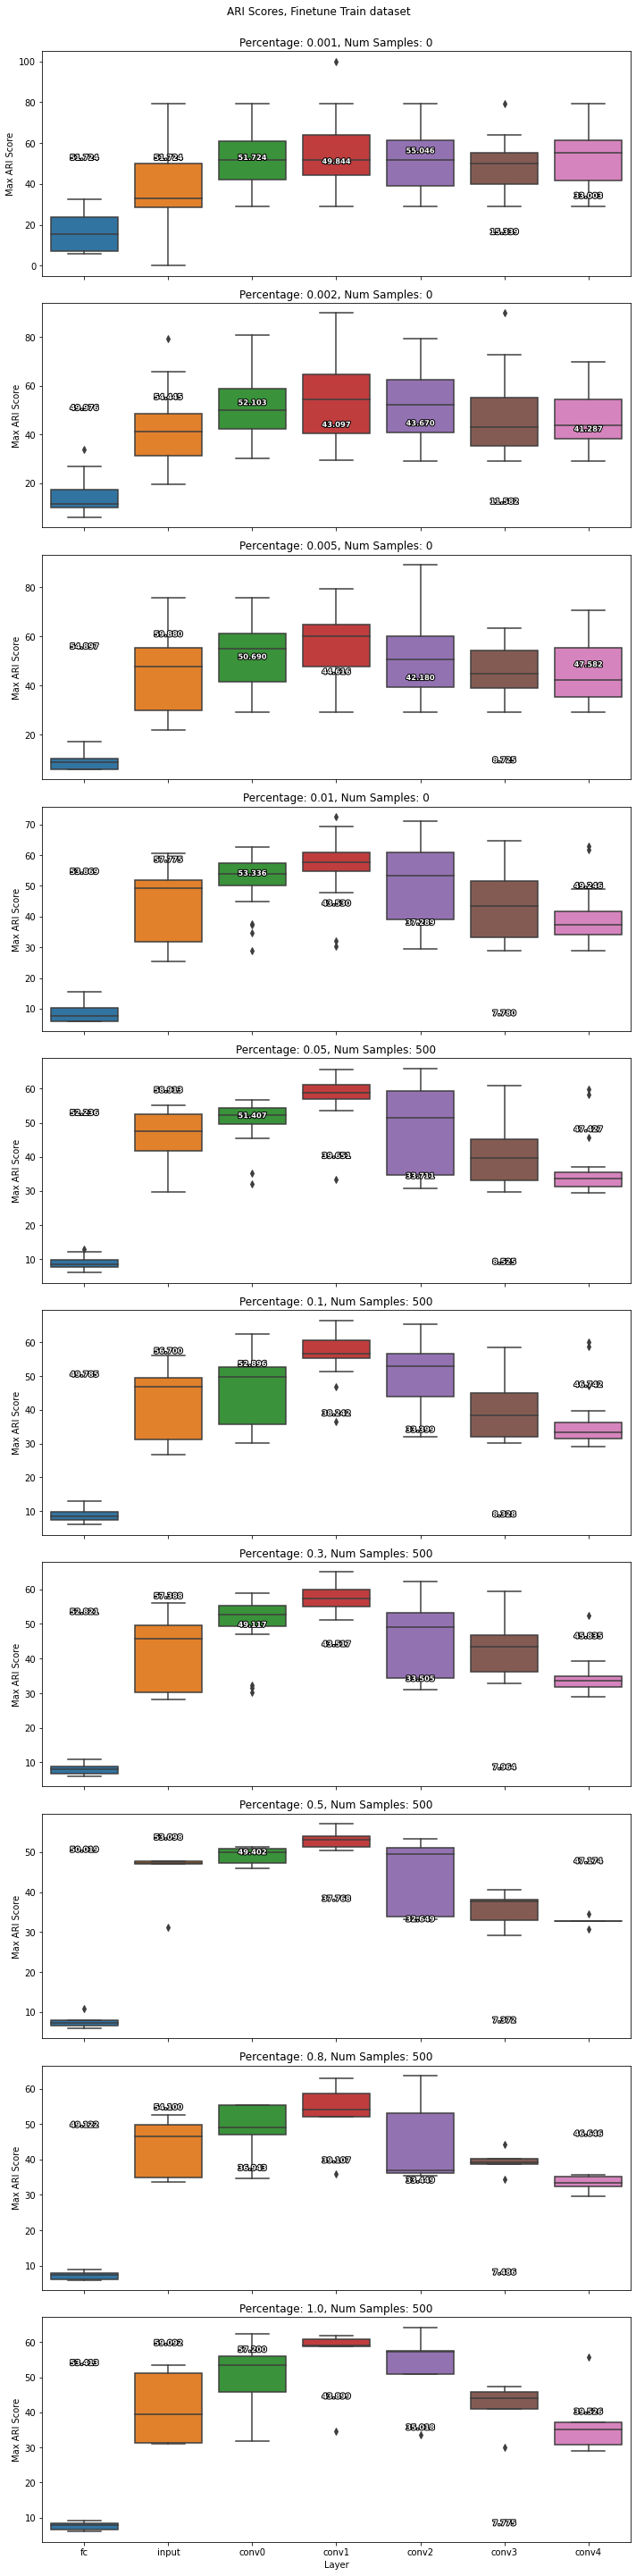

In [18]:
layer_names = ['fc', "input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4']
plot_ARI_scores_percentages(df, "Finetune", "Train", order=layer_names)

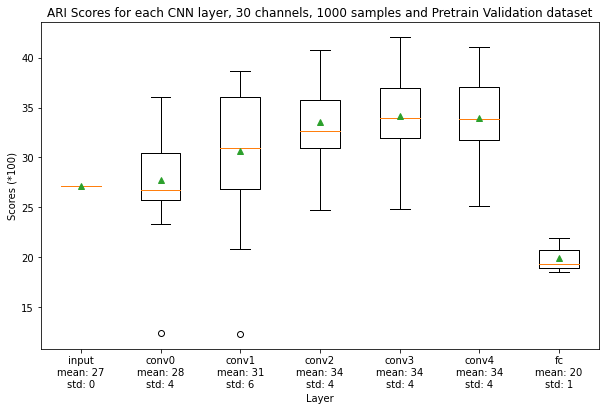

In [74]:
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']
plot_ARI_scores(pretraining_ari_scores, channel_ids, layer_names, num_samples=num_samples, dataset="Pretrain", split="Validation")

In [75]:
dataloader_wrapped.update_phase('finetune')
num_samples = 1000
channel_ids = range(params["num_channels"])
# channel_ids = [29]

finetune_ari_scores = get_ARI_scores(dataloader_wrapped.val_loader, num_samples, channel_ids)

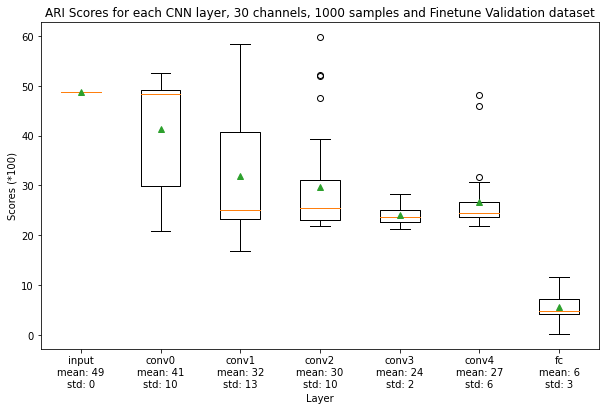

In [77]:
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']
plot_ARI_scores(finetune_ari_scores, channel_ids, layer_names, num_samples=num_samples, dataset="Finetune", split="Validation")